# Densities, Sector Seperation

Non-final visualisation for L=5 integrable circuit and L=10 non-integrable circuit. The former is sector seperated.

In [2]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
import pandas as pd

from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
def save_spectrum(spectrum, filename):
    csr_array = np.real(spectrum.get_spectrum(is_complex=False))
    np.savetxt(filename, csr_array)

def save_heatmap(heatmap, filename):
    n = heatmap.shape[0]
    grid = np.arange(n)
    x, y = np.meshgrid(grid, grid)

    heatmap = heatmap.flatten()
    x = x.flatten()
    y = y.flatten()

    data = np.array([x, y, heatmap]).T
    np.savetxt(filename, data)


def load_data(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Load the data using pandas
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    
    # Convert the DataFrame to a NumPy array
    data_array = data.to_numpy()
    
    return data_array

import re
import numpy as np

# pre-compile the regex for performance
_exp_pat = re.compile(r'\*\^([+-]?\d+)')


def to_complex_array(obj_arr: np.ndarray) -> np.ndarray:
    """
    Convert an array of strings of the form
      - 'a+bi*I'
      - 'a-bi*I'
      - 'a*^b+ci*I'
      - 'a*^b-ci*I'
    into a numpy array of complex numbers.
    
    Parameters
    ----------
    obj_arr : np.ndarray
        Object-dtype (or string-dtype) array where each entry is a string
        like '0.5+1.2*I' or '-3.9*^-7-0.37*I'.
    
    Returns
    -------
    np.ndarray
        Array of dtype complex128 with the same shape as obj_arr.
    """
    str_arr = obj_arr.astype(str)
    
    def _convert_one(s: str) -> str:
        # 1) replace "*^b" → "eb"
        s = _exp_pat.sub(r'e\1', s)
        # 2) replace "*I" → "j"
        s = s.replace('*I', 'j')
        return s
    
    # vectorize across the array
    vect = np.vectorize(_convert_one, otypes=[str])
    j_arr = vect(str_arr)
    
    # finally cast to complex128
    return j_arr.astype(np.complex128)


## Integrable L = 5, Sector Seperated

In [8]:
raw = load_data("data/T5_q0.dat")
csr = to_complex_array(raw)

C:\Users\krist\AppData\Local\Temp\ipykernel_9592\3837551426.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


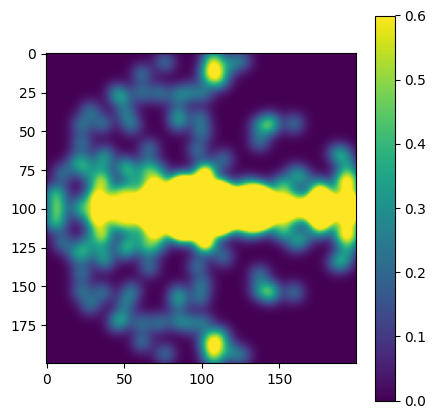

In [9]:
csr = Spectrum(csr, is_complex=True)
csr_coat = coat_spectrum(csr, sigma = 0.05, grid_size = 200)
csr_coat = csr_coat/np.max(csr_coat)

dA = 4/40000
norm = np.sum(csr_coat)*dA
csr_coat = csr_coat/norm


c_max = 0.6
fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_coat)
plt.colorbar()
plt.clim(0, c_max)
plt.savefig('figures/hist_integrable_L=5.png')
plt.show()

In [10]:
#save_spectrum(csr_integrable, 'book_keeping/integrable_crs_eigenvalues_L=5_retrieved.txt')
np.savetxt('book_keeping/figure2/hist_integrable_L=5.txt',csr_coat)

## Non-Integrable L = 10, Not Sector Seperated

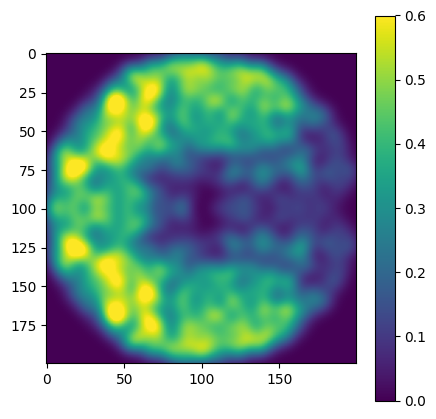

In [ ]:
model_list = pkl.load(open(f'../models/nonintegrable_model_4_L=10.model', 'rb'))

loss_list = []
spectrum_list = []
csr_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_list.append(csr)

csr = Spectrum(csr_list)
csr_coat = coat_spectrum(csr, sigma = 0.05, grid_size = 200)

dA = 4/40000
norm = np.sum(csr_coat)*dA
csr_coat = csr_coat/norm

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_coat)
plt.colorbar()
plt.clim(0, c_max)
plt.savefig('figures/hist_nonintegrable_L=10.png')
plt.show()

In [12]:
np.savetxt('book_keeping/figure2/hist_nonintegrable_L=10.txt', csr_coat)